## 환경 설정

In [ ]:
import zipfile
         
fantasy_zip = zipfile.ZipFile('/content/drive/My Drive/딥러닝/감성분석/2020-1-deeplearning-final.zip')
fantasy_zip.extractall('/content/drive/My Drive/딥러닝/감성분석')
 
fantasy_zip.close()

In [ ]:
import pandas as pd
from konlpy.tag import Okt
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping

## 데이터

In [ ]:
train = pd.read_csv('/content/drive/My Drive/딥러닝/감성분석/train.csv')
test = pd.read_csv('/content/drive/My Drive/딥러닝/감성분석/test.csv')
train.head()

,id,rating,raw,chr_token,nn_token
0,R024795,1,1982년도에 이런영화가 제작이 됐다는거 자체가 놀라운거라고. 재미없다고 씨부리는것...,1 9 8 2 년 도 에 이 런 영 화 가 제 작 이 됐 다 는 거 자 체 가 놀 ...,년도 영화 제작 거 자체 거 씨 것 엄매 뱃속 정자 난자 전 리를리감 독 전구 에디...
1,R068332,1,핸드핼드기법을 적절히 써가며 현실과 환상의 대비를 확연하게 보여주는 영화,핸 드 핼 드 기 법 을 적 절 히 써 가 며 현 실 과 환 상 의 대 비 를 확 ...,핸드 핼드 기법 현실 환상 대비 영화
2,R027236,1,....엑스맨을 깔끔하게 정리를 했다는 자체가 이미 뛰어난 영화라는 것을 증명하고 있다,. . . . 엑 스 맨 을 깔 끔 하 게 정 리 를 했 다 는 자 체 가 이 미 ...,엑스맨 정리 자체 영화 것 증명
3,R050965,0,뭐 이런 쓰레기 영화가 다있냐 인물관계도 정리안해줘 줄거리도 없어 내용도 ㅉㅉ,뭐 이 런 쓰 레 기 영 화 가 다 있 냐 인 물 관 계 도 정 리 안 해 줘 줄 ...,쓰레기 영화 인물 관계 정리안 줄거리 내용 ㅉ
4,R016317,0,육식공룡중에서 빌딩보다 더큰공룡이어딧노 ㅋㅋㅋㅋㅋㅋ,육 식 공 룡 중 에 서 빌 딩 보 다 더 큰 공 룡 이 어 딧 노 ㅋ ㅋ ㅋ ㅋ ㅋ ㅋ,육식 공 룡 중 빌딩 공룡 어딧노 ㅋ ㅋ


In [ ]:
train.groupby(['rating'])['id'].size()

rating
0    27255
1    27255
Name: id, dtype: int64

## 전처리

In [ ]:
train['raw'] = train['raw'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test['raw'] = test['raw'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train.head()

,id,rating,raw,chr_token,nn_token
0,R024795,1,년도에 이런영화가 제작이 됐다는거 자체가 놀라운거라고 재미없다고 씨부리는것들아 니들...,1 9 8 2 년 도 에 이 런 영 화 가 제 작 이 됐 다 는 거 자 체 가 놀 ...,년도 영화 제작 거 자체 거 씨 것 엄매 뱃속 정자 난자 전 리를리감 독 전구 에디...
1,R068332,1,핸드핼드기법을 적절히 써가며 현실과 환상의 대비를 확연하게 보여주는 영화,핸 드 핼 드 기 법 을 적 절 히 써 가 며 현 실 과 환 상 의 대 비 를 확 ...,핸드 핼드 기법 현실 환상 대비 영화
2,R027236,1,엑스맨을 깔끔하게 정리를 했다는 자체가 이미 뛰어난 영화라는 것을 증명하고 있다,. . . . 엑 스 맨 을 깔 끔 하 게 정 리 를 했 다 는 자 체 가 이 미 ...,엑스맨 정리 자체 영화 것 증명
3,R050965,0,뭐 이런 쓰레기 영화가 다있냐 인물관계도 정리안해줘 줄거리도 없어 내용도 ㅉㅉ,뭐 이 런 쓰 레 기 영 화 가 다 있 냐 인 물 관 계 도 정 리 안 해 줘 줄 ...,쓰레기 영화 인물 관계 정리안 줄거리 내용 ㅉ
4,R016317,0,육식공룡중에서 빌딩보다 더큰공룡이어딧노 ㅋㅋㅋㅋㅋㅋ,육 식 공 룡 중 에 서 빌 딩 보 다 더 큰 공 룡 이 어 딧 노 ㅋ ㅋ ㅋ ㅋ ㅋ ㅋ,육식 공 룡 중 빌딩 공룡 어딧노 ㅋ ㅋ


## 토큰화

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','에','와','한','하다']
okt = Okt()

In [ ]:
train_tok = []
for sentence in train['raw']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    train_tok.append(temp_X)

test_tok = []
for sentence in test['raw']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    test_tok.append(temp_X)

In [ ]:
train_token = []
for item in train_tok:
  train_token.append(' '.join(item))
test_token = []
for item in test_tok:
  test_token.append(' '.join(item))

In [ ]:
labels = train['rating'].values

# train, test 합쳐서 토큰화 진행
texts = list(pd.concat([pd.Series(train_seq), pd.Series(test_seq)]))

In [ ]:
# 토큰화
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

# 정수 인코딩
seq = tokenizer.texts_to_sequences(texts)
maxlen = max(len(x) for x in seq)

word2idx = tokenizer.word_index
word2idx[0] = 'PAD'
idx2words = {j:i for i,j in word2idx.items()}

# padding
seq = pad_sequences(seq,maxlen=maxlen)

# train, test 분할
train_seq = seq[:len(labels)]
test_seq = seq[len(labels):]

## 모델링

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_seq, labels, test_size=0.2, stratify = labels)

In [ ]:
model = Sequential()
model.add(Embedding(max_words+1, 128,input_length = maxlen))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 69, 128)           1280128   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,411,841
Trainable params: 1,411,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',patience = 4)])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 34886 samples, validate on 8722 samples
Epoch 1/15
34886/34886 [==============================] - 154s 4ms/step - loss: 0.4208 - acc: 0.8069 - val_loss: 0.3677 - val_acc: 0.8411
Epoch 2/15
34886/34886 [==============================] - 152s 4ms/step - loss: 0.3258 - acc: 0.8603 - val_loss: 0.3553 - val_acc: 0.8440
Epoch 3/15
34886/34886 [==============================] - 150s 4ms/step - loss: 0.3024 - acc: 0.8731 - val_loss: 0.3568 - val_acc: 0.8460
Epoch 4/15
34886/34886 [==============================] - 150s 4ms/step - loss: 0.2868 - acc: 0.8798 - val_loss: 0.3458 - val_acc: 0.8496
Epoch 5/15
34886/34886 [==============================] - 151s 4ms/step - loss: 0.2709 - acc: 0.8880 - val_loss: 0.3528 - val_acc: 0.8489
Epoch 6/15
34886/34886 [==============================] - 149s 4ms/step - loss: 0.2547 - acc: 0.8957 - val_loss: 0.3590 - val_acc: 0.8430
Epoch 7/15
34886/34886 [==============================] - 149s 4ms/step - loss: 0.2389 - acc: 0.9042 - val_loss: 0.3549 - v

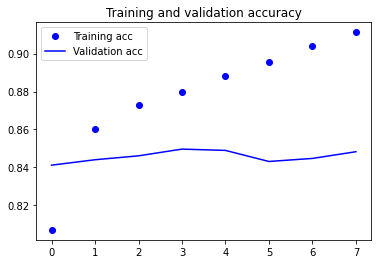

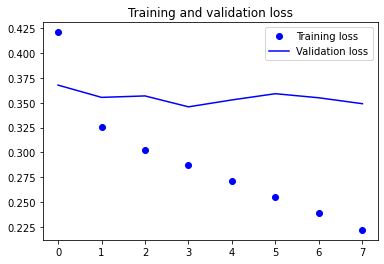

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Submission

In [ ]:
pred = model.predict_classes(x_test)
pred = pred.flatten()
(pred == y_test).mean()

0.852779306549257

In [ ]:
pred = model.predict_classes(test_seq)
pred = pred.flatten()
submit = pd.DataFrame({'id':test.id, 'pred':pred})
submit.to_csv('token_LSTM.csv',index=False)